## 0. Check validity of the data

## 1.Data Preparation Pipeline

### Windowing
- Split the series into overlapping or non-overlapping windows (e.g., 100-tick windows).
- Ensure no future leakage (causal splitting).

### Mask Preparation
- Create a mask tensor where all values are `1` (observed). No missing data!


In [62]:
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime

df = pd.read_csv("/Users/aleksandr/Desktop/Meta_Test.csv")
df = df.dropna()

In [65]:
# Would be lovely to optimise parameters used in function for more efficient data preprocessing
from preprocess_td import preprocess_tick_data

df_clean, df_diagnostics, outlier_counter = preprocess_tick_data(df)

Starting preprocessing with 570771 rows
After filtering trading hours: 282810 rows
After cleaning outliers: 282301 rows
Final clean dataset: 278585 rows

Outlier counts by detection method:
  zscore: 64
  extreme_deviation: 69
  isolated_point: 390
  price_reversal: 93
  market_open_artifact: 0
  timestamp_group: 34
  price_velocity: 3703
  suspicious_cluster: 52
  wavelet_outlier: 24


In [66]:
df = df_clean
df = df.drop(columns="VOLATILITY")

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import fft, stats, optimize
from scipy.signal import spectrogram

def estimate_advanced_tick_volatility(df, symbol_col='SYMBOL', timestamp_col='TIMESTAMP', 
                                    price_col='VALUE', volume_col='VOLUME',
                                    method='all', window_size=1000, step_size=100,
                                    num_freqs=50, smooth_factor=0.5):
    """
    Estimate tick-level volatility using advanced methods including:
    1. Localized Fourier Analysis (Malliavin-Mancino on sliding windows)
    2. Maximum Likelihood Estimation (MLE) with stochastic volatility model
    3. Wavelet-based multi-scale volatility
    
    Parameters:
    -----------
    df : pd.DataFrame
        Tick data
    symbol_col : str
        Column name for instrument symbols
    timestamp_col : str
        Column name for timestamps
    price_col : str
        Column name for price data
    volume_col : str
        Column name for volume data
    method : str
        Method to use: 'fourier', 'mle', 'wavelet', or 'all'
    window_size : int
        Size of sliding window (in number of ticks)
    step_size : int
        Step size for sliding window
    num_freqs : int
        Number of Fourier frequencies to use
    smooth_factor : float
        Smoothing factor for volatility estimates (0-1)
        
    Returns:
    --------
    pd.DataFrame
        Original dataframe with added volatility columns
    """
    print(f"Estimating advanced tick-level volatility for {len(df)} ticks...")
    
    # Create a copy to avoid modifying the original
    result_df = df.copy()
    
    # Process each symbol separately
    for symbol in df[symbol_col].unique():
        symbol_mask = result_df[symbol_col] == symbol
        symbol_data = result_df[symbol_mask].copy().sort_values(timestamp_col)
        
        # Convert timestamps to datetime for tick time calculations
        symbol_data[timestamp_col] = pd.to_datetime(symbol_data[timestamp_col])
        
        # Calculate log prices and returns
        symbol_data['log_price'] = np.log(symbol_data[price_col])
        symbol_data['return'] = symbol_data['log_price'].diff().fillna(0)
        symbol_data['abs_return'] = np.abs(symbol_data['return'])
        
        # Calculate time between ticks in seconds
        symbol_data['time_delta'] = symbol_data[timestamp_col].diff().dt.total_seconds().fillna(0.001)
        
        # Initialize volatility columns
        if method in ['fourier', 'all']:
            symbol_data['fourier_vol'] = np.nan
        if method in ['mle', 'all']:
            symbol_data['mle_vol'] = np.nan
        if method in ['wavelet', 'all']:
            symbol_data['wavelet_vol'] = np.nan
        
        # Total number of ticks
        n_ticks = len(symbol_data)
        
        # 1. LOCALIZED FOURIER VOLATILITY ESTIMATION
        if method in ['fourier', 'all']:
            print(f"Computing localized Fourier volatility for {symbol}...")
            
            # Prepare storage for windowed volatility estimates
            fourier_volatility = np.zeros(n_ticks)
            
            # Calculate volatility for each window
            windows_calculated = 0
            
            for start_idx in range(0, n_ticks, step_size):
                end_idx = min(start_idx + window_size, n_ticks)
                
                # Skip windows that are too small
                if end_idx - start_idx < 50:
                    continue
                
                window_data = symbol_data.iloc[start_idx:end_idx]
                
                # Get times and log prices for this window
                times = window_data['time_delta'].cumsum().values
                log_prices = window_data['log_price'].values
                T = times[-1] - times[0]
                
                if T <= 0:
                    continue  # Skip windows with no time variation
                
                try:
                    # Compute Fourier coefficients for this window
                    fourier_coeffs = compute_malliavin_mancino_fourier(log_prices, times, T, num_freqs)
                    
                    # Compute integrated variance for this window
                    power_spectrum = fourier_coeffs['power']
                    integrated_variance = np.sum(power_spectrum) / (2 * T)
                    
                    # Convert to per-tick volatility
                    window_volatility = np.sqrt(integrated_variance)
                    
                    # Assign to all ticks in this window
                    window_range = slice(start_idx, end_idx)
                    fourier_volatility[window_range] = np.maximum(
                        fourier_volatility[window_range],
                        window_volatility
                    )
                    
                    windows_calculated += 1
                    
                except Exception as e:
                    print(f"Warning: Error in Fourier calculation for window {start_idx}-{end_idx}: {e}")
            
            print(f"Calculated Fourier volatility using {windows_calculated} windows")
            
            # Fill any remaining zeros with nearby values
            if windows_calculated > 0:
                for i in range(n_ticks):
                    if fourier_volatility[i] == 0:
                        # Find nearest non-zero value
                        left_idx = max(0, i-1)
                        while left_idx >= 0 and fourier_volatility[left_idx] == 0:
                            left_idx -= 1
                        
                        right_idx = min(n_ticks-1, i+1)
                        while right_idx < n_ticks and fourier_volatility[right_idx] == 0:
                            right_idx += 1
                        
                        # Use closest value
                        if left_idx >= 0 and right_idx < n_ticks:
                            if i - left_idx <= right_idx - i:
                                fourier_volatility[i] = fourier_volatility[left_idx]
                            else:
                                fourier_volatility[i] = fourier_volatility[right_idx]
                        elif left_idx >= 0:
                            fourier_volatility[i] = fourier_volatility[left_idx]
                        elif right_idx < n_ticks:
                            fourier_volatility[i] = fourier_volatility[right_idx]
            
            # Smooth the volatility estimates
            if smooth_factor > 0:
                window_smooth = int(window_size * smooth_factor)
                fourier_volatility = pd.Series(fourier_volatility).rolling(
                    window=window_smooth, min_periods=1, center=True
                ).mean().values
            
            # Save results
            symbol_data['fourier_vol'] = fourier_volatility
        
        # 2. MLE-BASED VOLATILITY ESTIMATION
        if method in ['mle', 'all']:
            print(f"Computing MLE-based volatility for {symbol}...")
            
            # Prepare arrays for MLE volatility
            mle_volatility = np.zeros(n_ticks)
            
            # Use a sliding window approach for MLE
            windows_calculated = 0
            
            for start_idx in range(0, n_ticks, step_size):
                end_idx = min(start_idx + window_size, n_ticks)
                
                # Skip windows that are too small
                if end_idx - start_idx < 50:
                    continue
                
                window_data = symbol_data.iloc[start_idx:end_idx]
                returns = window_data['return'].values
                
                try:
                    # Use MLE to fit a stochastic volatility model (GARCH-like)
                    # Here we use a simplified approach with constant volatility in the window
                    def neg_log_likelihood(params):
                        # Simple model where returns follow normal distribution with estimated volatility
                        sigma = params[0]  # volatility parameter
                        if sigma <= 0:
                            return 1e10  # Penalty for invalid parameters
                        
                        # Log-likelihood for normal distribution
                        ll = -np.sum(stats.norm.logpdf(returns, loc=0, scale=sigma))
                        return ll
                    
                    # Initial guess based on sample standard deviation
                    initial_guess = [np.std(returns)]
                    
                    # Optimize to find MLE parameters
                    result = optimize.minimize(
                        neg_log_likelihood, 
                        initial_guess,
                        bounds=[(1e-10, None)]  # Ensure positive volatility
                    )
                    
                    # Extract estimated volatility
                    mle_vol = result.x[0]
                    
                    # Assign to all ticks in this window
                    window_range = slice(start_idx, end_idx)
                    mle_volatility[window_range] = np.maximum(
                        mle_volatility[window_range],
                        mle_vol
                    )
                    
                    windows_calculated += 1
                    
                except Exception as e:
                    print(f"Warning: Error in MLE calculation for window {start_idx}-{end_idx}: {e}")
            
            print(f"Calculated MLE volatility using {windows_calculated} windows")
            
            # Fill any remaining zeros with nearby values (same as for Fourier)
            if windows_calculated > 0:
                for i in range(n_ticks):
                    if mle_volatility[i] == 0:
                        # Find nearest non-zero value (same logic as before)
                        left_idx = max(0, i-1)
                        while left_idx >= 0 and mle_volatility[left_idx] == 0:
                            left_idx -= 1
                        
                        right_idx = min(n_ticks-1, i+1)
                        while right_idx < n_ticks and mle_volatility[right_idx] == 0:
                            right_idx += 1
                        
                        # Use closest value
                        if left_idx >= 0 and right_idx < n_ticks:
                            if i - left_idx <= right_idx - i:
                                mle_volatility[i] = mle_volatility[left_idx]
                            else:
                                mle_volatility[i] = mle_volatility[right_idx]
                        elif left_idx >= 0:
                            mle_volatility[i] = mle_volatility[left_idx]
                        elif right_idx < n_ticks:
                            mle_volatility[i] = mle_volatility[right_idx]
            
            # Smooth the volatility estimates
            if smooth_factor > 0:
                window_smooth = int(window_size * smooth_factor)
                mle_volatility = pd.Series(mle_volatility).rolling(
                    window=window_smooth, min_periods=1, center=True
                ).mean().values
            
            # Save results
            symbol_data['mle_vol'] = mle_volatility
        
        # 3. WAVELET-BASED MULTI-SCALE VOLATILITY
        if method in ['wavelet', 'all']:
            print(f"Computing wavelet-based volatility for {symbol}...")
            
            # Use the spectrogram function to perform a windowed FFT (similar to wavelet analysis)
            # This gives us frequency components over time
            returns = symbol_data['return'].values
            
            # Need to handle NaN/zero values
            returns = np.nan_to_num(returns)
            
            try:
                # Calculate spectrogram (windowed FFT)
                f, t, Sxx = spectrogram(
                    returns,
                    fs=1.0,  # Sampling frequency (normalized)
                    nperseg=min(256, n_ticks//10),  # Window size
                    noverlap=min(128, n_ticks//20),  # Overlap
                    scaling='spectrum'  # Return spectrum
                )
                
                # Extract volatility at different frequency bands
                # Low frequencies (long-term volatility)
                low_freq_idx = slice(0, len(f)//10)
                # Medium frequencies
                med_freq_idx = slice(len(f)//10, len(f)//3)
                # High frequencies (short-term volatility)
                high_freq_idx = slice(len(f)//3, None)
                
                # Calculate power in each frequency band over time
                low_power = np.sqrt(np.sum(Sxx[low_freq_idx, :], axis=0))
                med_power = np.sqrt(np.sum(Sxx[med_freq_idx, :], axis=0))
                high_power = np.sqrt(np.sum(Sxx[high_freq_idx, :], axis=0))
                
                # Interpolate to get values for each tick
                wavelet_vol = np.zeros(n_ticks)
                tick_positions = np.linspace(0, 1, n_ticks)
                t_positions = np.linspace(0, 1, len(t))
                
                # Combine frequency bands with more weight to medium frequencies
                combined_power = (low_power * 0.3 + med_power * 0.5 + high_power * 0.2)
                
                # Interpolate to get values for each tick
                wavelet_vol = np.interp(tick_positions, t_positions, combined_power)
                
                # Scale to match typical volatility levels
                scale_factor = np.std(returns) / np.mean(wavelet_vol)
                wavelet_vol *= scale_factor
                
                # Smooth the results
                if smooth_factor > 0:
                    window_smooth = int(window_size * smooth_factor)
                    wavelet_vol = pd.Series(wavelet_vol).rolling(
                        window=window_smooth, min_periods=1, center=True
                    ).mean().values
                
                symbol_data['wavelet_vol'] = wavelet_vol
                
            except Exception as e:
                print(f"Warning: Error in wavelet calculation: {e}")
                # Fallback to EWMA volatility
                symbol_data['wavelet_vol'] = np.sqrt(
                   (symbol_data['return']**2).ewm(span=window_size//5, min_periods=10).mean()
                )
        
        # 4. COMBINED ADAPTIVE VOLATILITY
        if method == 'all':
            # Combine the methods using weights that can adapt based on return characteristics
            valid_methods = []
            
            if 'fourier_vol' in symbol_data.columns and not symbol_data['fourier_vol'].isna().all():
                valid_methods.append('fourier_vol')
            
            if 'mle_vol' in symbol_data.columns and not symbol_data['mle_vol'].isna().all():
                valid_methods.append('mle_vol')
                
            if 'wavelet_vol' in symbol_data.columns and not symbol_data['wavelet_vol'].isna().all():
                valid_methods.append('wavelet_vol')
            
            if len(valid_methods) > 0:
                # Initialize with equal weights
                weights = {method: 1.0 / len(valid_methods) for method in valid_methods}
                
                # Calculate combined volatility
                symbol_data['combined_vol'] = 0
                for method in valid_methods:
                    symbol_data['combined_vol'] += weights[method] * symbol_data[method]
        
        # Copy volatility estimates back to the main dataframe
        vol_columns = [col for col in symbol_data.columns 
                     if col.endswith('_vol') and col in symbol_data.columns]
        
        for col in vol_columns:
            result_df.loc[symbol_mask, col] = symbol_data[col]
        
        # Also include the return for reference
        result_df.loc[symbol_mask, 'return'] = symbol_data['return']
    
    print("Completed advanced tick-level volatility estimation")
    return result_df

def compute_malliavin_mancino_fourier(log_prices, times, T, num_freqs):
    """
    Compute Fourier coefficients using Malliavin-Mancino estimator.
    
    Parameters:
    -----------
    log_prices : numpy.ndarray
        Log prices
    times : numpy.ndarray
        Observation times in seconds
    T : float
        Total time period in seconds
    num_freqs : int
        Number of Fourier frequencies to use
        
    Returns:
    --------
    dict
        Fourier coefficients and related data
    """
    # Calculate returns
    returns = np.diff(log_prices)
    return_times = times[1:]
    
    # Generate Fourier frequencies
    freqs = np.arange(1, num_freqs + 1)
    
    # Initialize Fourier coefficient arrays
    fourier_cos = np.zeros(num_freqs)
    fourier_sin = np.zeros(num_freqs)
    
    # Compute Fourier coefficients
    for i, freq in enumerate(freqs):
        # Calculate angular frequency
        omega = 2 * np.pi * freq / T
        
        # Calculate Fourier coefficients for this frequency
        cos_term = np.cos(omega * return_times)
        sin_term = np.sin(omega * return_times)
        
        fourier_cos[i] = np.sum(returns * cos_term)
        fourier_sin[i] = np.sum(returns * sin_term)
    
    # Calculate power spectrum (for volatility)
    power_spectrum = fourier_cos**2 + fourier_sin**2
    
    # Calculate autocorrelation function via inverse Fourier transform
    acf = fft.irfft(power_spectrum, n=num_freqs*2)
    
    return {
        'cos': fourier_cos,
        'sin': fourier_sin,
        'power': power_spectrum,
        'acf': acf,
        'freqs': freqs
    }

Estimating advanced tick-level volatility for 278585 ticks...
Computing localized Fourier volatility for META.O...
Calculated Fourier volatility using 1392 windows
Computing MLE-based volatility for META.O...
Calculated MLE volatility using 1393 windows
Computing wavelet-based volatility for META.O...
Completed advanced tick-level volatility estimation


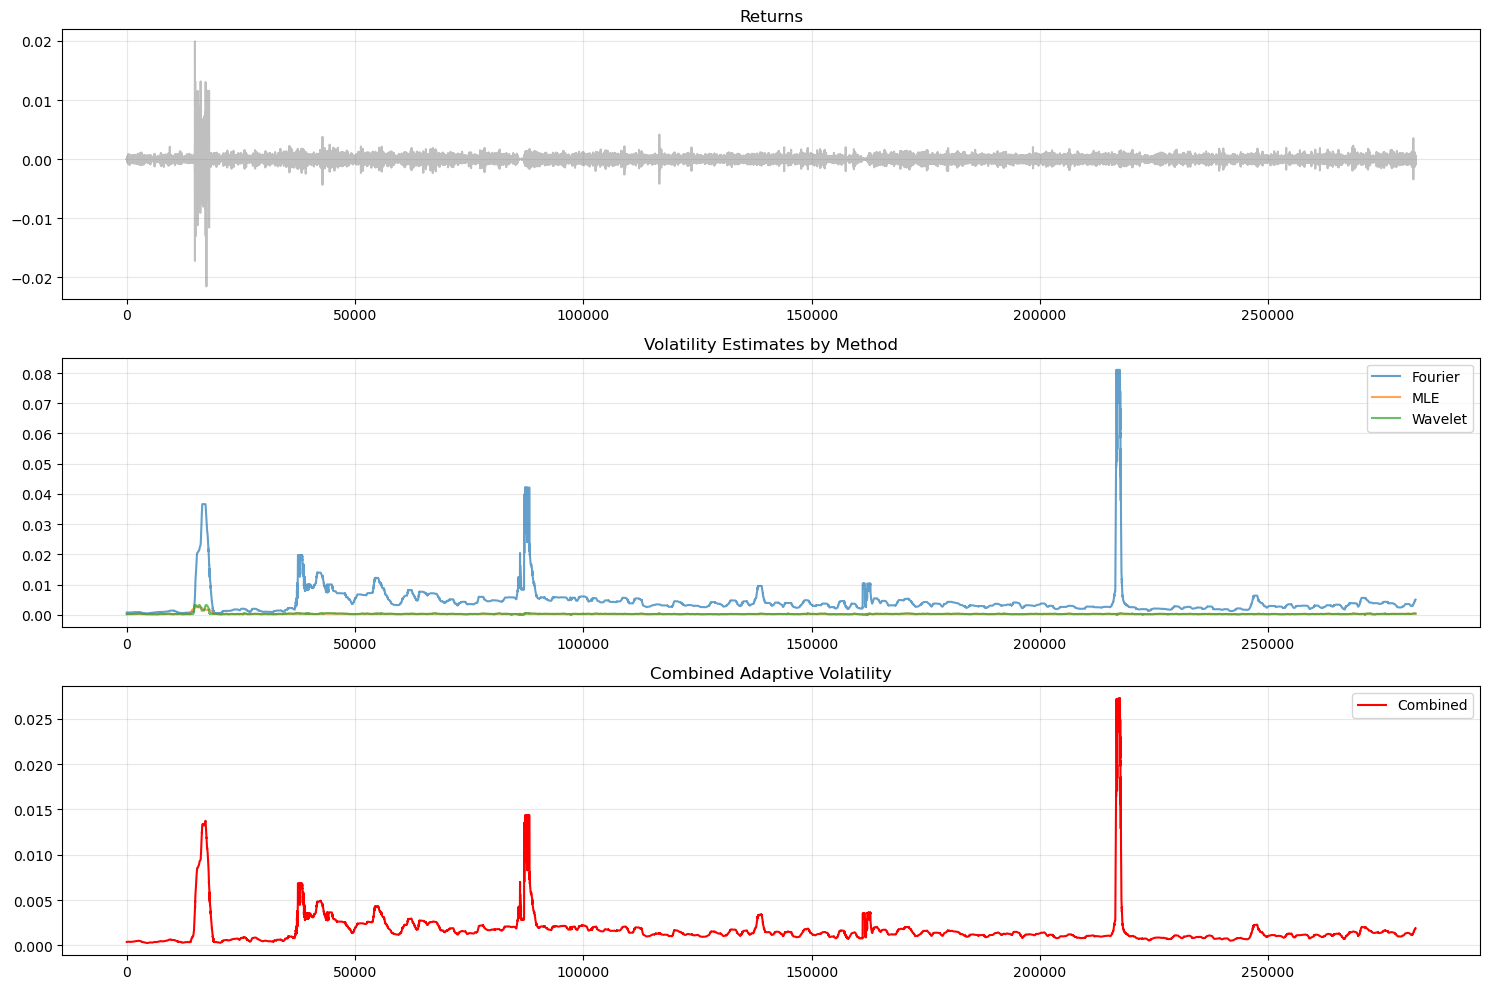

Volatility Summary Statistics:

fourier_vol:
count    278585.000000
mean          0.004508
std           0.006027
min           0.000429
25%           0.002481
50%           0.003346
75%           0.004749
max           0.081050
Name: fourier_vol, dtype: float64

mle_vol:
count    278585.000000
mean          0.000268
std           0.000206
min           0.000088
25%           0.000213
50%           0.000239
75%           0.000271
max           0.002481
Name: mle_vol, dtype: float64

wavelet_vol:
count    278585.000000
mean          0.000291
std           0.000237
min           0.000011
25%           0.000222
50%           0.000262
75%           0.000309
max           0.003267
Name: wavelet_vol, dtype: float64

combined_vol:
count    278585.000000
mean          0.001689
std           0.002067
min           0.000261
25%           0.000981
50%           0.001282
75%           0.001761
max           0.027268
Name: combined_vol, dtype: float64


In [83]:
# Use the advanced volatility estimation
df_with_vol = estimate_advanced_tick_volatility(
    df, 
    symbol_col='SYMBOL', 
    timestamp_col='TIMESTAMP', 
    price_col='VALUE',
    volume_col='VOLUME',
    method='all',  # Use all three methods: 'fourier', 'mle', 'wavelet'
    window_size=1000,  # Window size for local estimation
    step_size=200,     # Step size between windows
    num_freqs=50,      # Number of Fourier frequencies
    smooth_factor=0.3  # Smoothing factor (0-1)
)

# Plot the results
plt.figure(figsize=(15, 10))

# Plot returns
plt.subplot(3, 1, 1)
plt.plot(df_with_vol['return'], color='gray', alpha=0.5)
plt.title('Returns')
plt.grid(True, alpha=0.3)

# Plot the different volatility methods
plt.subplot(3, 1, 2)
if 'fourier_vol' in df_with_vol.columns:
    plt.plot(df_with_vol['fourier_vol'], label='Fourier', alpha=0.7)
if 'mle_vol' in df_with_vol.columns:
    plt.plot(df_with_vol['mle_vol'], label='MLE', alpha=0.7)
if 'wavelet_vol' in df_with_vol.columns:
    plt.plot(df_with_vol['wavelet_vol'], label='Wavelet', alpha=0.7)
plt.legend()
plt.title('Volatility Estimates by Method')
plt.grid(True, alpha=0.3)

# Plot combined volatility
plt.subplot(3, 1, 3)
if 'combined_vol' in df_with_vol.columns:
    plt.plot(df_with_vol['combined_vol'], color='red', label='Combined')
    plt.title('Combined Adaptive Volatility')
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()

# Print some summary statistics
print("Volatility Summary Statistics:")
for col in df_with_vol.columns:
    if col.endswith('_vol'):
        print(f"\n{col}:")
        print(df_with_vol[col].describe())

In [ ]:
# Windowing using volatility

def windowing(df):
    constant = 0.01
    vol_counter = 0
    windows = []
    temp_array = []
    for i in range(len(df)):
        if vol_counter >= constant:
            windows.append(temp_array)
            temp_array = []
            vol_counter = 0
            temp_array.append(df.iloc[i])
        else:
            vol_counter += vol_counter + df["VOLATILITY"].iloc[i]
            temp_array.append(df.iloc[i])
    return windows
windows = windowing(df)

## 2. Synthetic Noise Injection (Training Only)

To train CSDI to denoise, simulate realistic market microstructure noise:

### Noise Types:
- **Bid-Ask Bounce:** Randomly flip prices between bid/ask within the spread.
- **Order Flow Noise:** Add autocorrelated noise to simulate trade clustering.
- **Latency Jitter:** Perturb timestamps slightly (optional).

### Corruption Function:
- For each training batch, apply noise to the clean data to create noisy input.

## 3. Model Architecture Adaptations

Modify the original CSDI code (GitHub) for denoising:

### Remove Imputation Logic:
- Delete code blocks that handle missing value imputation.

### Time Embeddings:
- Encode irregular timestamps as sinusoidal embeddings (normalized to [0,1]).

### Conditioning Mechanism:
- Use the noisy input as the conditional context (instead of partial observations).

### Diffusion Process:
- Use the original diffusion steps but disable masking (all positions are observed).
- Adjust the noise schedule (β) to match financial noise characteristics.


## 4. Training Pipeline

**Objective:** Learn to reverse the diffusion process conditioned on noisy ticks.

### Inputs:
- **noisy_data:** Corrupted ticks (price, volume, etc.).
- **mask:** All ones (no missing data).
- **time_embeddings:** Encoded timestamps.

### Forward Process:
- Gradually add Gaussian noise to `noisy_data` across diffusion timesteps.
- Forward Process: Replace Gaussian SDE with a market-realistic stochastic process.

### Reverse Process:
- Train the model to predict the score (gradient) to denoise the data.

### Loss Function:
- Weighted MSE between predicted and true noise at each diffusion step.

## 5. Key Functions to Implement

### Data Loader:
```python
def load_tick_data():
    """Reads raw ticks and converts to windowed sequences."""
    pass

def inject_microstructure_noise():
    """Adds synthetic bid-ask bounce, order flow noise."""
    pass
```

### Time Embeddings:
```python
def encode_timestamps():
    """Converts irregular timestamps to continuous embeddings."""
    pass
```

### Diffusion Utils:
```python
def beta_scheduler():
    """Defines the noise schedule (linear, cosine, etc.)."""
    pass

def q_sample():
    """Forward diffusion process (adding noise)."""
    pass
```

### Model:
```python
class ConditionalScoreModel:
    """Modified CSDI backbone (transformer/TCN)."""
    pass

def train_step():
    """Computes loss and updates weights."""
    pass
```

## 6. Training Process

### Hyperparameters:
- Diffusion steps (`T=1000`), learning rate (`1e-4`), batch size (`64`).
- Noise schedule (e.g., `beta_start=1e-4`, `beta_end=0.02`).

### Training Loop:
For each batch:
1. Generate noisy data via `inject_microstructure_noise()`.
2. Compute time embeddings for irregular timestamps.
3. **Forward pass:** Corrupt noisy data with diffusion.
4. **Reverse pass:** Predict denoised data.
5. Update model weights via gradient descent.

### Checkpointing:
- Save model weights periodically (e.g., every epoch).
- Track validation loss on a held-out tick dataset.

## 7. Validation & Testing

### Metrics:
- **Reconstruction Loss:** MSE between denoised and clean data (if synthetic).
- **Volatility Consistency:** Compare realized volatility of raw vs. denoised data.
- **Microstructure Preservation:** Autocorrelation of trade signs.

### Visual Checks:
- Plot raw vs. denoised ticks (ensure no new timestamps are added).

## 8. Deployment Pipeline

### Preprocessing:
- Normalize new tick data using the same scaler from training.
- Encode timestamps.

### Inference:
- Run the trained CSDI in reverse diffusion mode with `mask=1`.

### Postprocessing:
- Inverse-transform normalized denoised data.